In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, precision_score, 
                             recall_score, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df = df.drop_duplicates()

# Drop multicollinearity features
df = df.drop(['emp.var.rate', 'nr.employed'], axis=1)

# Separate features and target
X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})
print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Dataset shape: (41176, 18)
Target distribution: {0: 36537, 1: 4639}


In [6]:
# Cell 3: Encode Categorical Variables
categorical_cols = X.select_dtypes(include='object').columns.tolist()
le_dict = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_dict[col] = le

print(f"\nCategorical columns encoded: {len(categorical_cols)}")


Categorical columns encoded: 10


In [7]:
# Cell 4: Train-Test Split (NO scaling needed for Decision Tree)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 32940
Test set size: 8236


In [9]:
# Cell 5: Train Decision Tree with Hyperparameter Tuning
# Limited depth to improve interpretability and avoid overfitting
dt_classifier = DecisionTreeClassifier(
    max_depth=7,  # Limit depth for interpretability
    min_samples_split=50,  # Require at least 50 samples to split
    min_samples_leaf=20,  # Require at least 20 samples in leaf nodes
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)
dt_classifier.fit(X_train, y_train)
print("Decision Tree trained successfully!")

Decision Tree trained successfully!


In [10]:
# Cell 6: Make Predictions
y_train_pred = dt_classifier.predict(X_train)
y_train_pred_proba = dt_classifier.predict_proba(X_train)[:, 1]

y_test_pred = dt_classifier.predict(X_test)
y_test_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

In [11]:
# Cell 7: Model Evaluation - Training Set
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_train_pred == y_train).mean():.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")


TRAINING SET PERFORMANCE
Accuracy: 0.8471
Precision: 0.4207
Recall: 0.9475
F1-Score: 0.5826
ROC-AUC: 0.9506


In [12]:
# Cell 8: Model Evaluation - Test Set
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Conversion', 'Conversion']))


TEST SET PERFORMANCE
Accuracy: 0.8439
Precision: 0.4152
Recall: 0.9450
F1-Score: 0.5770
ROC-AUC: 0.9425

Classification Report (Test Set):
               precision    recall  f1-score   support

No Conversion       0.99      0.83      0.90      7308
   Conversion       0.42      0.95      0.58       928

     accuracy                           0.84      8236
    macro avg       0.70      0.89      0.74      8236
 weighted avg       0.93      0.84      0.87      8236



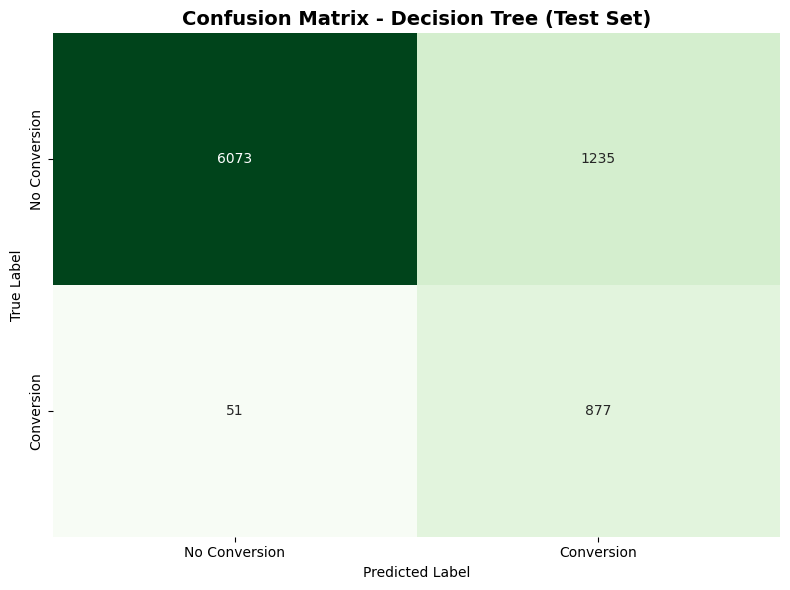

In [13]:
# Cell 9: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Confusion Matrix - Decision Tree (Test Set)', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

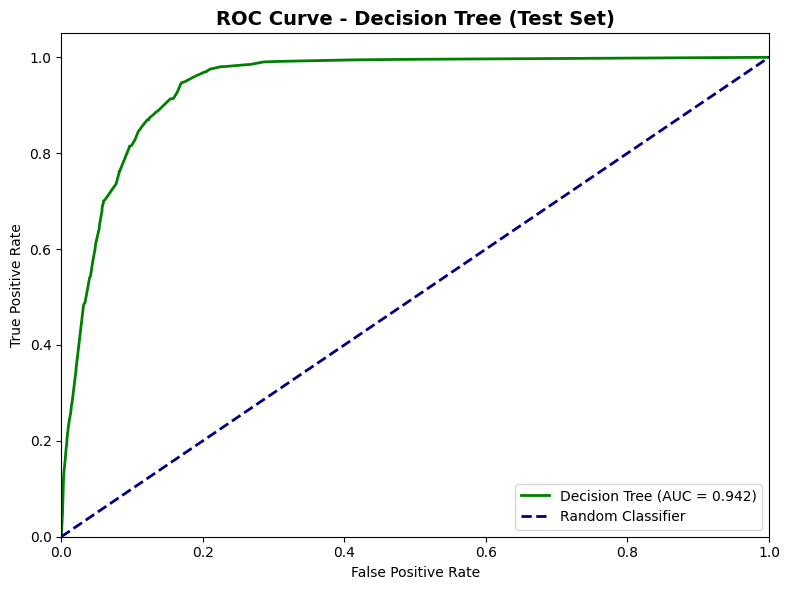

In [14]:
# Cell 10: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Test Set)', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [15]:
# Cell 11: Feature Importance Analysis
feature_names = X_encoded.columns.tolist()
feature_importance = dt_classifier.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Top 15)")
print("="*60)
print(importance_df.head(15).to_string(index=False))


FEATURE IMPORTANCE (Top 15)
       Feature  Importance
      duration    0.509812
     euribor3m    0.375454
         month    0.071066
cons.price.idx    0.011410
         pdays    0.010436
   day_of_week    0.005057
     education    0.003677
 cons.conf.idx    0.002522
       contact    0.002401
      campaign    0.002253
           age    0.001918
      previous    0.001136
       marital    0.001125
           job    0.000641
      poutcome    0.000460


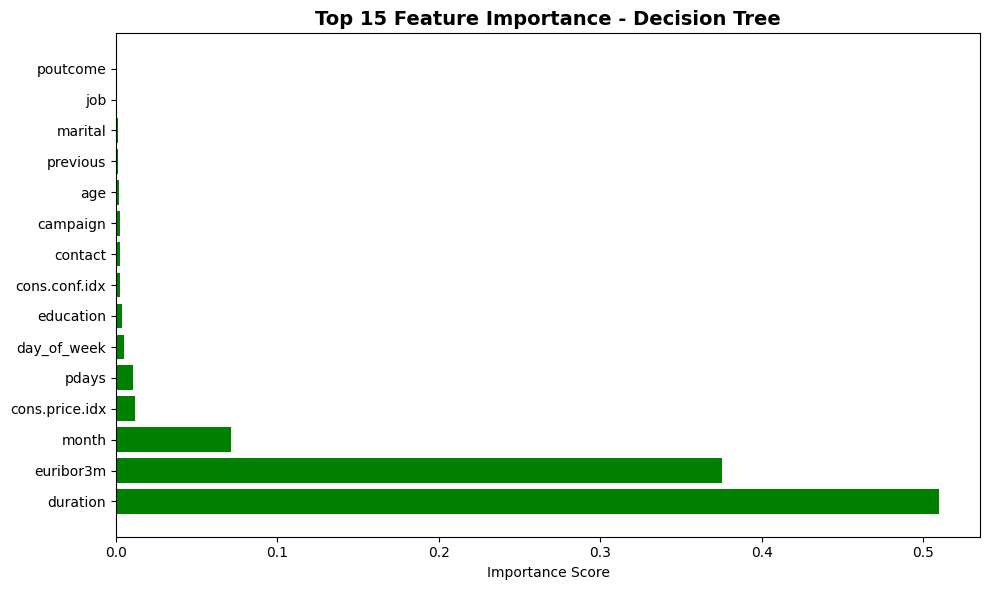

In [16]:
# Cell 12: Visualize Feature Importance
plt.figure(figsize=(10, 6))
top_n = 15
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'], color='green')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importance - Decision Tree', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

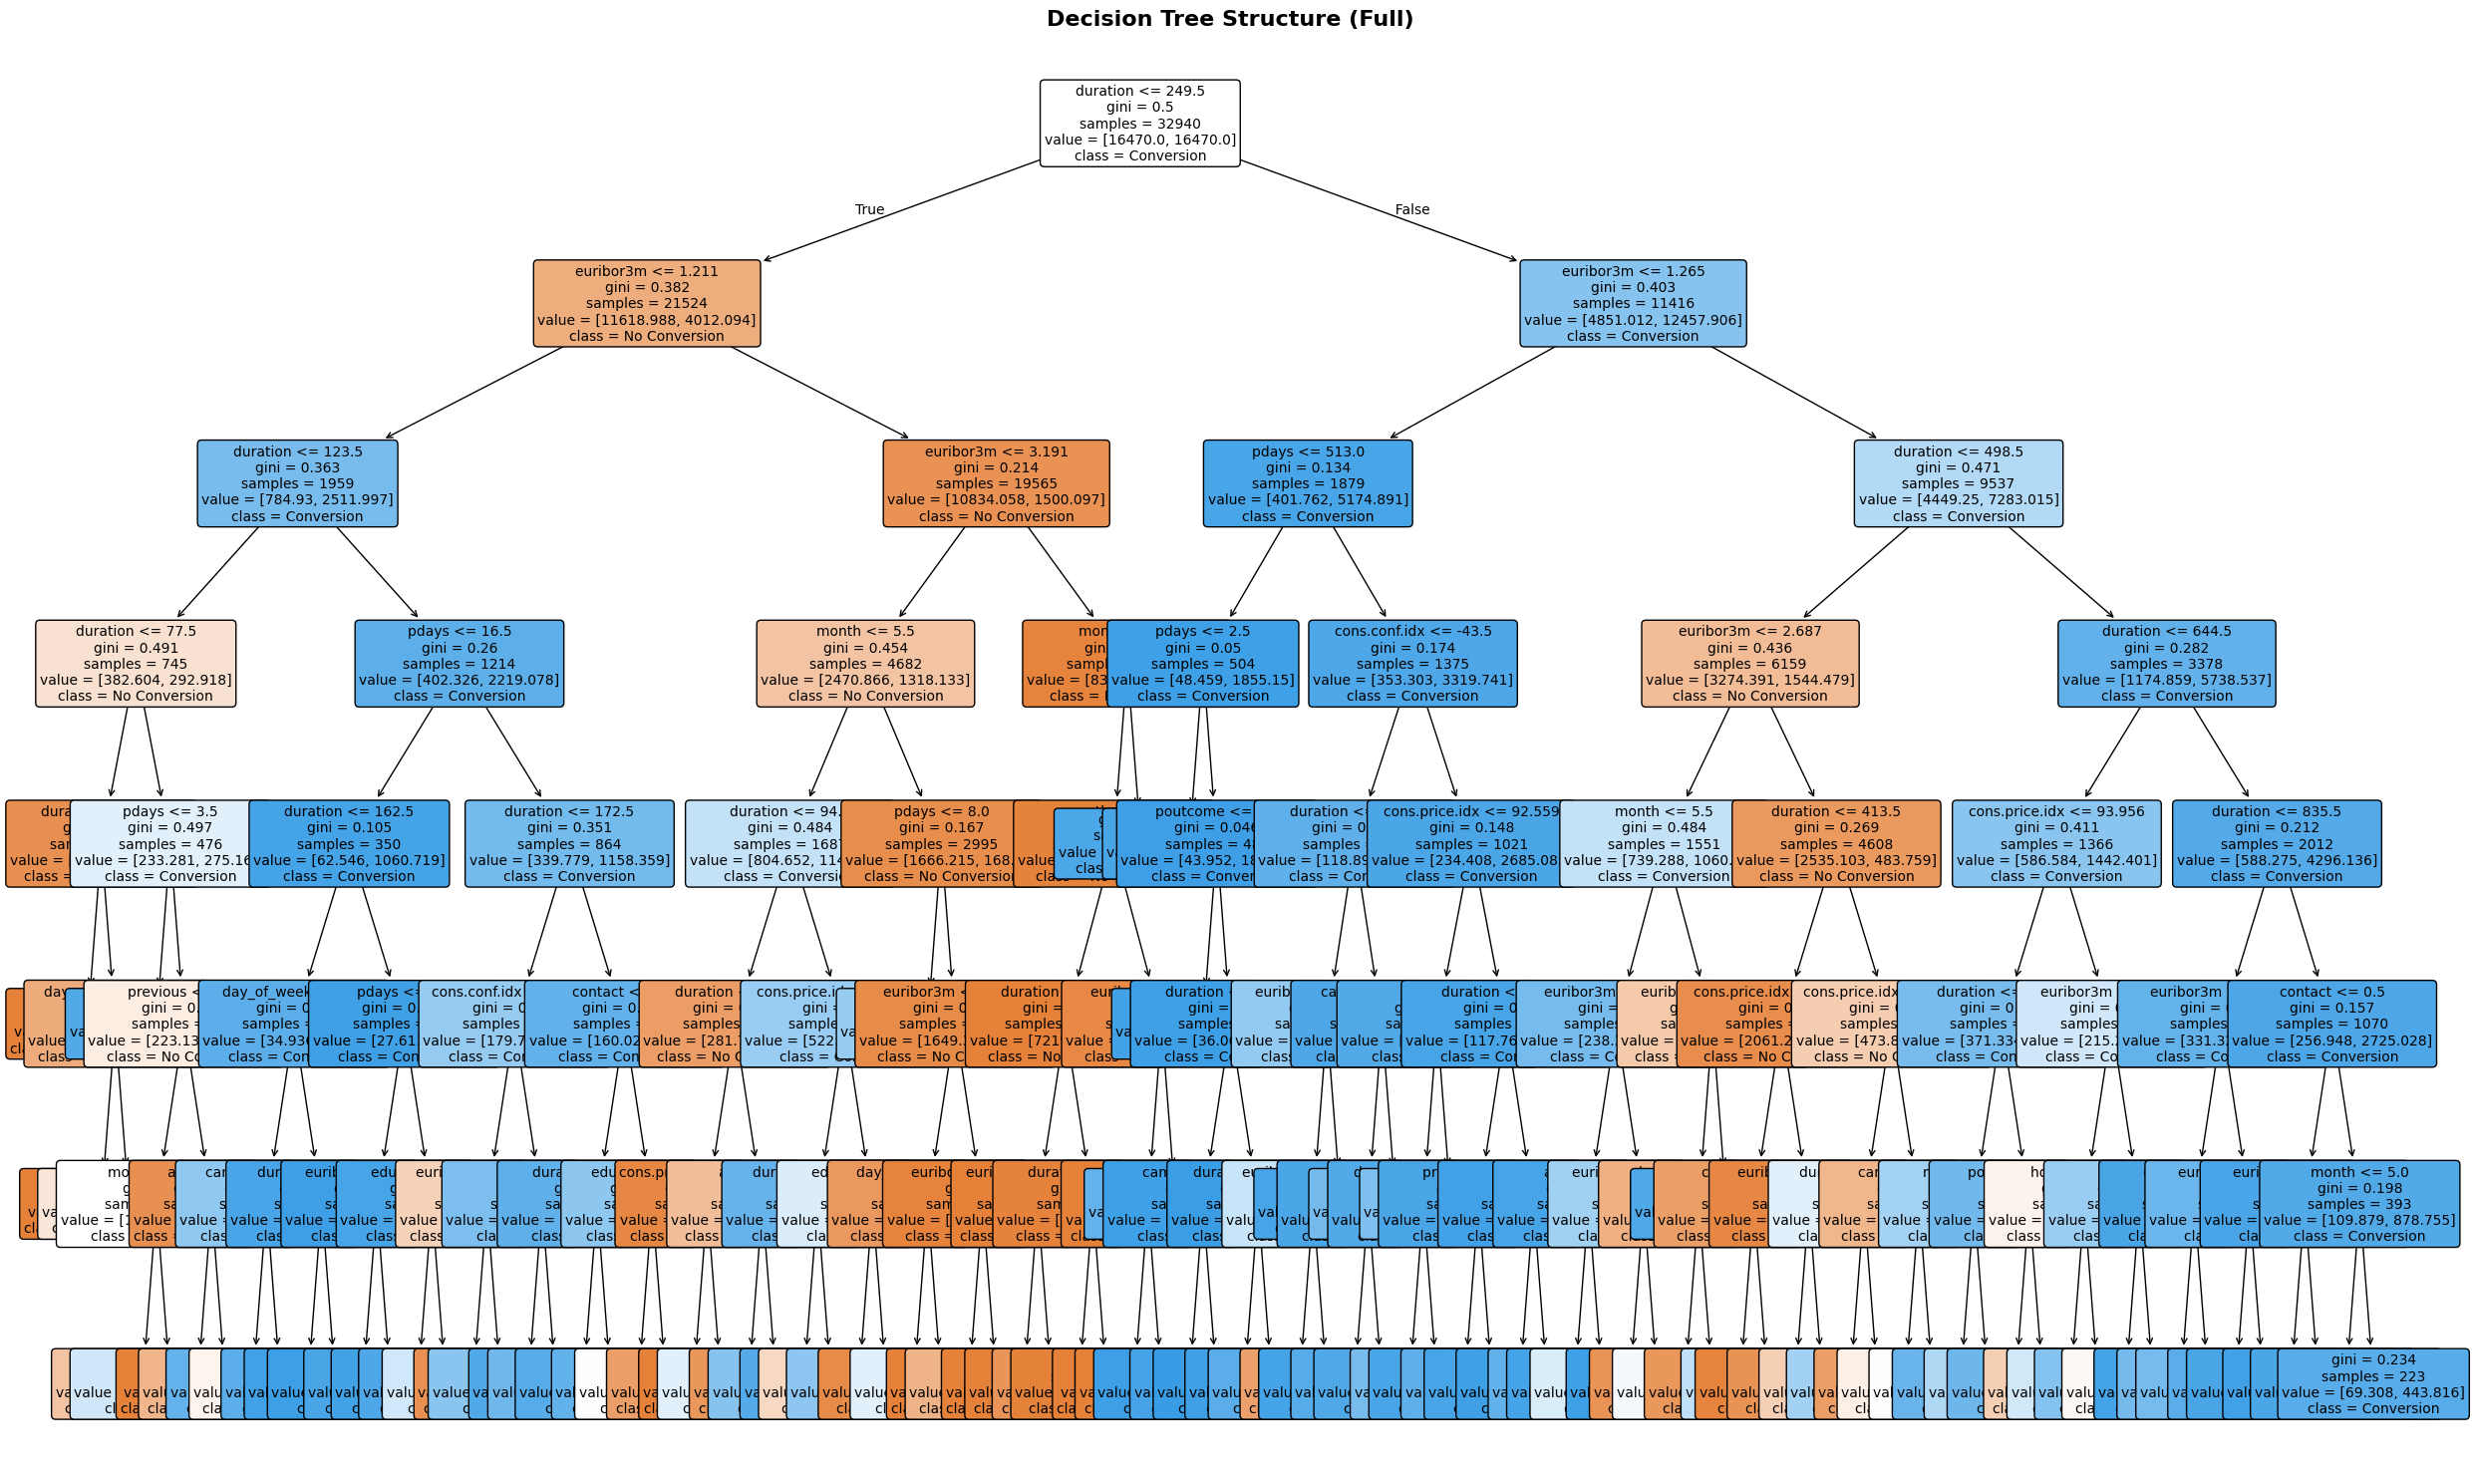

In [17]:
# Cell 13: Visualize Decision Tree (Full)
plt.figure(figsize=(25, 15))
plot_tree(dt_classifier, 
          feature_names=feature_names,
          class_names=['No Conversion', 'Conversion'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Structure (Full)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# Cell 14: Extract Tree Rules as Text
tree_rules = export_text(dt_classifier, feature_names=feature_names)
print("\n" + "="*60)
print("DECISION TREE RULES (Text Format)")
print("="*60)
print(tree_rules[:2000])  # Print first 2000 characters


DECISION TREE RULES (Text Format)
|--- duration <= 249.50
|   |--- euribor3m <= 1.21
|   |   |--- duration <= 123.50
|   |   |   |--- duration <= 77.50
|   |   |   |   |--- duration <= 62.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- duration >  62.50
|   |   |   |   |   |--- day_of_week <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- day_of_week >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- duration >  77.50
|   |   |   |   |--- pdays <= 3.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- pdays >  3.50
|   |   |   |   |   |--- previous <= 1.50
|   |   |   |   |   |   |--- month <= 2.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- month >  2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- previous >  1.50
|   |   |   |   |   |   |--- age <= 37.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  37.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

In [19]:
# Cell 15: Depth and Node Analysis
print("\n" + "="*60)
print("TREE STRUCTURE ANALYSIS")
print("="*60)
print(f"Tree Depth: {dt_classifier.get_depth()}")
print(f"Number of Leaves: {dt_classifier.get_n_leaves()}")
print(f"Number of Total Nodes: {dt_classifier.tree_.node_count}")


TREE STRUCTURE ANALYSIS
Tree Depth: 7
Number of Leaves: 95
Number of Total Nodes: 189


In [20]:
# Cell 16: Compare with Logistic Regression (Performance Comparison)
print("\n" + "="*60)
print("LOGISTIC REGRESSION vs DECISION TREE COMPARISON")
print("="*60)

comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Logistic Regression': [0.8414, 0.4067, 0.8879, 0.5579, 0.9281],
    'Decision Tree': [
        (y_test_pred == y_test).mean(),
        precision_score(y_test, y_test_pred),
        recall_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred),
        roc_auc_score(y_test, y_test_pred_proba)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


LOGISTIC REGRESSION vs DECISION TREE COMPARISON
   Metric  Logistic Regression  Decision Tree
 Accuracy               0.8414       0.843856
Precision               0.4067       0.415246
   Recall               0.8879       0.945043
 F1-Score               0.5579       0.576974
  ROC-AUC               0.9281       0.942481


In [22]:
# Cell 18: Leaf Node Analysis - What rules lead to high conversion?
print("\n" + "="*60)
print("LEAF NODE DISTRIBUTION")
print("="*60)
leaf_values = dt_classifier.tree_.value
leaf_samples = dt_classifier.tree_.n_node_samples

high_conversion_leaves = []
for i, (values, samples) in enumerate(zip(leaf_values, leaf_samples)):
    if i in dt_classifier.tree_.children_left or i in dt_classifier.tree_.children_right:
        continue  # Skip non-leaf nodes
    
    if samples > 0:
        conversion_rate = values[0][1] / samples  # Class 1 conversions
        if conversion_rate > 0.3:  # High conversion leaves
            high_conversion_leaves.append({
                'Leaf_ID': i,
                'Samples': int(samples),
                'Conversion_Rate': conversion_rate,
                'Total_Conversions': int(values[0][1])
            })

if high_conversion_leaves:
    high_conv_df = pd.DataFrame(high_conversion_leaves).sort_values('Conversion_Rate', ascending=False)
    print("\nLeaf Nodes with >30% Conversion Rate:")
    print(high_conv_df.to_string(index=False))


LEAF NODE DISTRIBUTION
